In [1]:
%cd ..
%load_ext autoreload

/ems/elsc-labs/mezer-a/niv.amos/repos/qMRI Analyzer - Code


In [2]:
import enum
import seaborn as sns
from data_handling.Data_Processor import DataProcessor
from data_handling.Data_Reader import DataReader
import constants
import os
from statistics_methods.Statistics import StatisticsWrapper
from statistics_methods.plots import PlotsManager
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, fcluster
import wandb
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_squared_error as MSE
from xgboost import XGBRegressor
from sklearn.cluster import KMeans
from scipy import stats
from scipy.stats import linregress
import copy
import nibabel as nib

Constants

In [3]:
chosen_rois_dict = constants.SUB_CORTEX_DICT
params_to_work_with = constants.ALL_PARAMS

Load the data and proccess it

In [4]:
def load_data(data_path, outliers=[]):
    col_names = ['subjects', 'Age', 'Gender', 'Clinc_group']
    subjects_raw_data = DataProcessor(data_path, chosen_rois_dict, chosen_rois_dict, col_names).get_data_proccessed()
    analyzed_data = StatisticsWrapper.calc_median_per_subject_per_parameter_per_ROI(subjects_raw_data, params_to_work_with)
    chosen_data = StatisticsWrapper.chose_relevant_data(analyzed_data, chosen_rois_dict, params_to_work_with, params_to_work_with)

    chosen_data = chosen_data[~chosen_data.subjects.isin(outliers)]

    ctl_subjects = chosen_data[chosen_data.Clinc_group == 'CTL']
    pd_subjects = chosen_data[chosen_data.Clinc_group == 'PD']

    return chosen_data, ctl_subjects, pd_subjects
    

In [12]:
outliers = ['PD056_YK', 'PD110_DS', 'PD004_KC', 'PD050_YM', 'PD101_DS', 'PD028_YO']
# outliers = []
chosen_data_raw, ctl_subjects_raw, pd_subjects_raw = load_data(constants.PATH_TO_PD_SUB_CORTEX_all_params_raw, outliers=outliers)
chosen_data_z_score, ctl_subjects_z_score, pd_subjects_z_score = load_data(constants.PATH_TO_PD_SUB_CORTEX_all_params_z_score, outliers=outliers)

print(f'ctl: {ctl_subjects_raw.subjects.nunique()}, pd: {pd_subjects_raw.subjects.nunique()}')

ctl: 16, pd: 29


In [11]:
DataProcessor.outliers_counter(pd_subjects_raw, params_to_work_with, chosen_rois_dict)

outliers counter: {'PD056_YK': 16, 'PD004_KC': 9, 'PD028_YO': 5, 'PD041_CS': 5, 'PD011_WA': 4, 'PD076_YE': 3, 'PD040_JW': 3, 'PD067_JL': 2, 'PD043_RB': 2, 'PD025_LZ': 2, 'PD055_SC': 2, 'PD037_ES': 2, 'PD085_YS': 2, 'PD079_EM': 1, 'PD044_TS': 1, 'PD074_RH': 1, 'PD010_KR': 1, 'PD024_BE': 1, 'PD112_JI': 1, 'PD106_AF': 1, 'PD014_SD': 1, 'PD102_AM': 1}


## Raw data analysis 

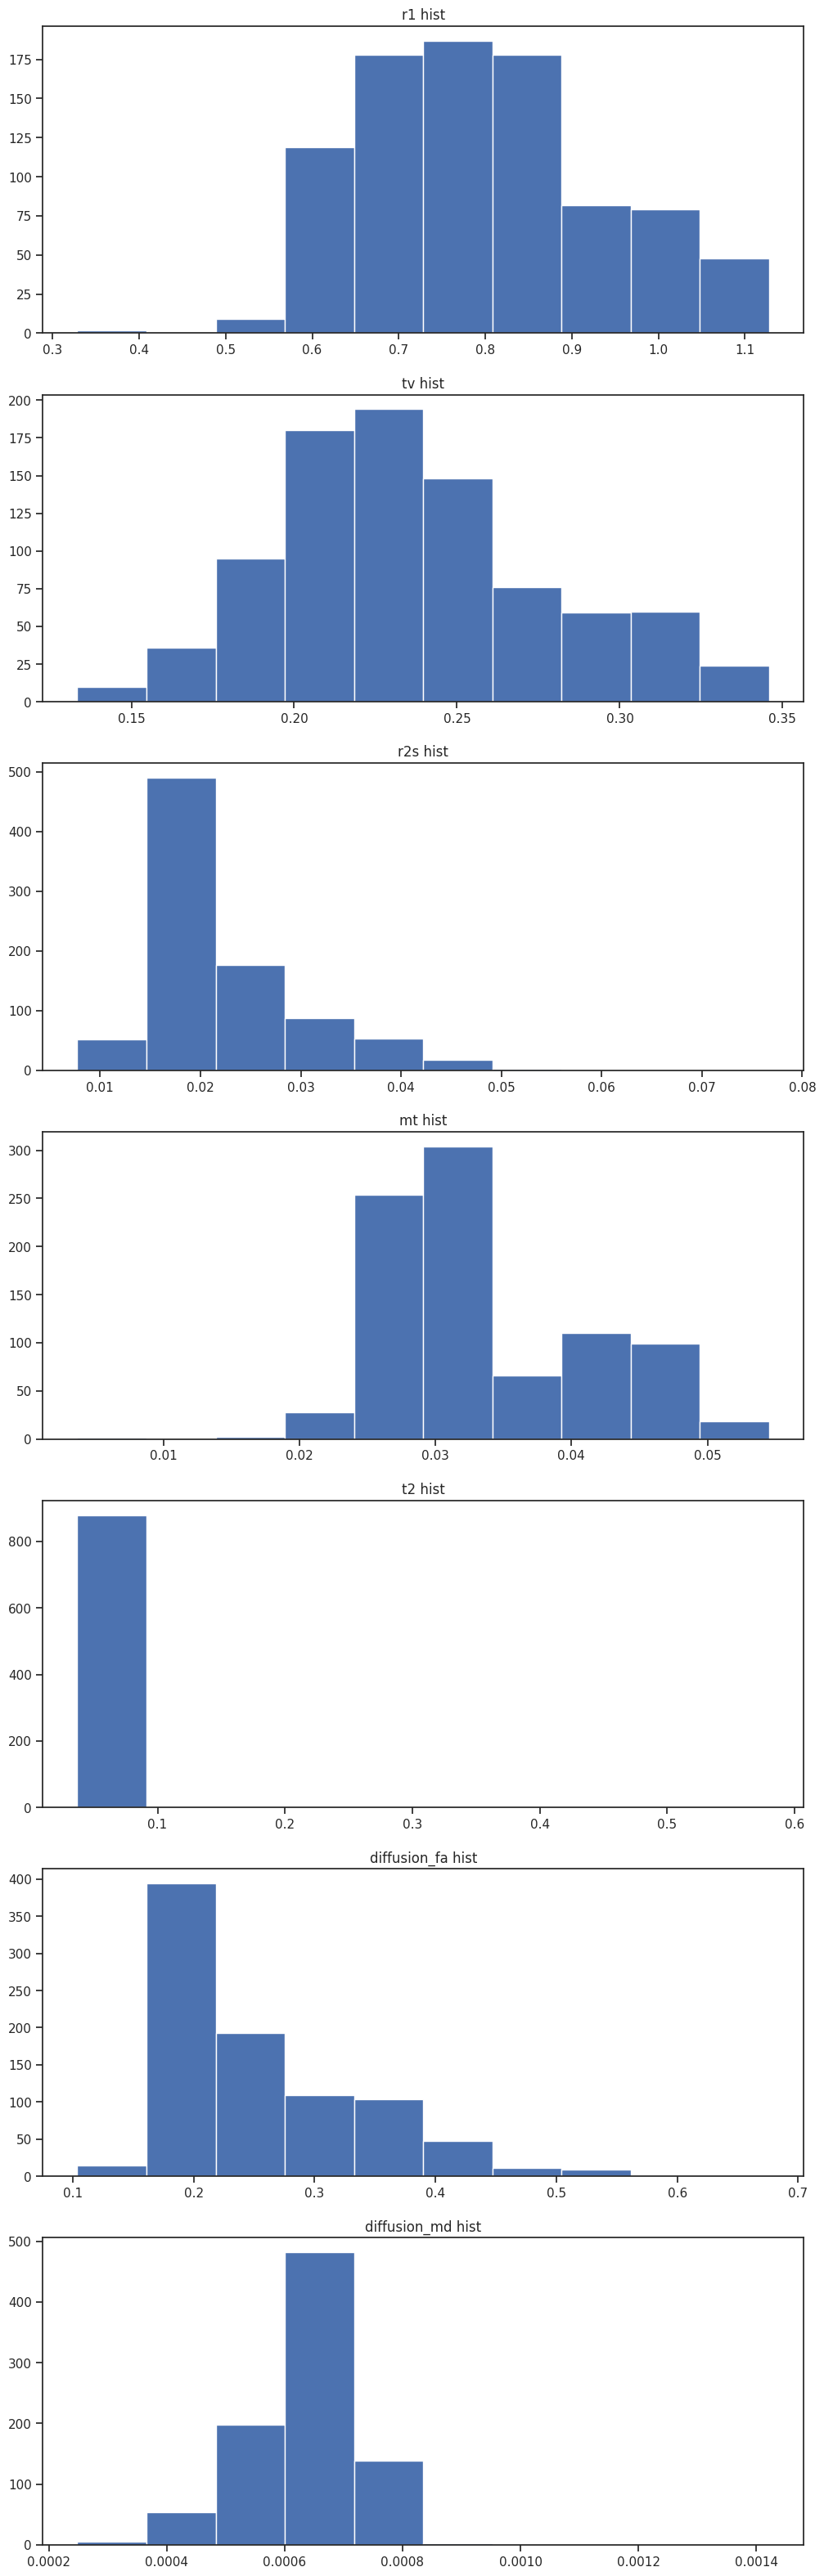

In [8]:
fig, ax = plt.subplots(nrows=7, ncols=1, figsize=(12, 40))

for i, param in  enumerate(params_to_work_with):
    ax[i].set_title(f'{param} hist')
    ax[i].hist(chosen_data_raw[param])

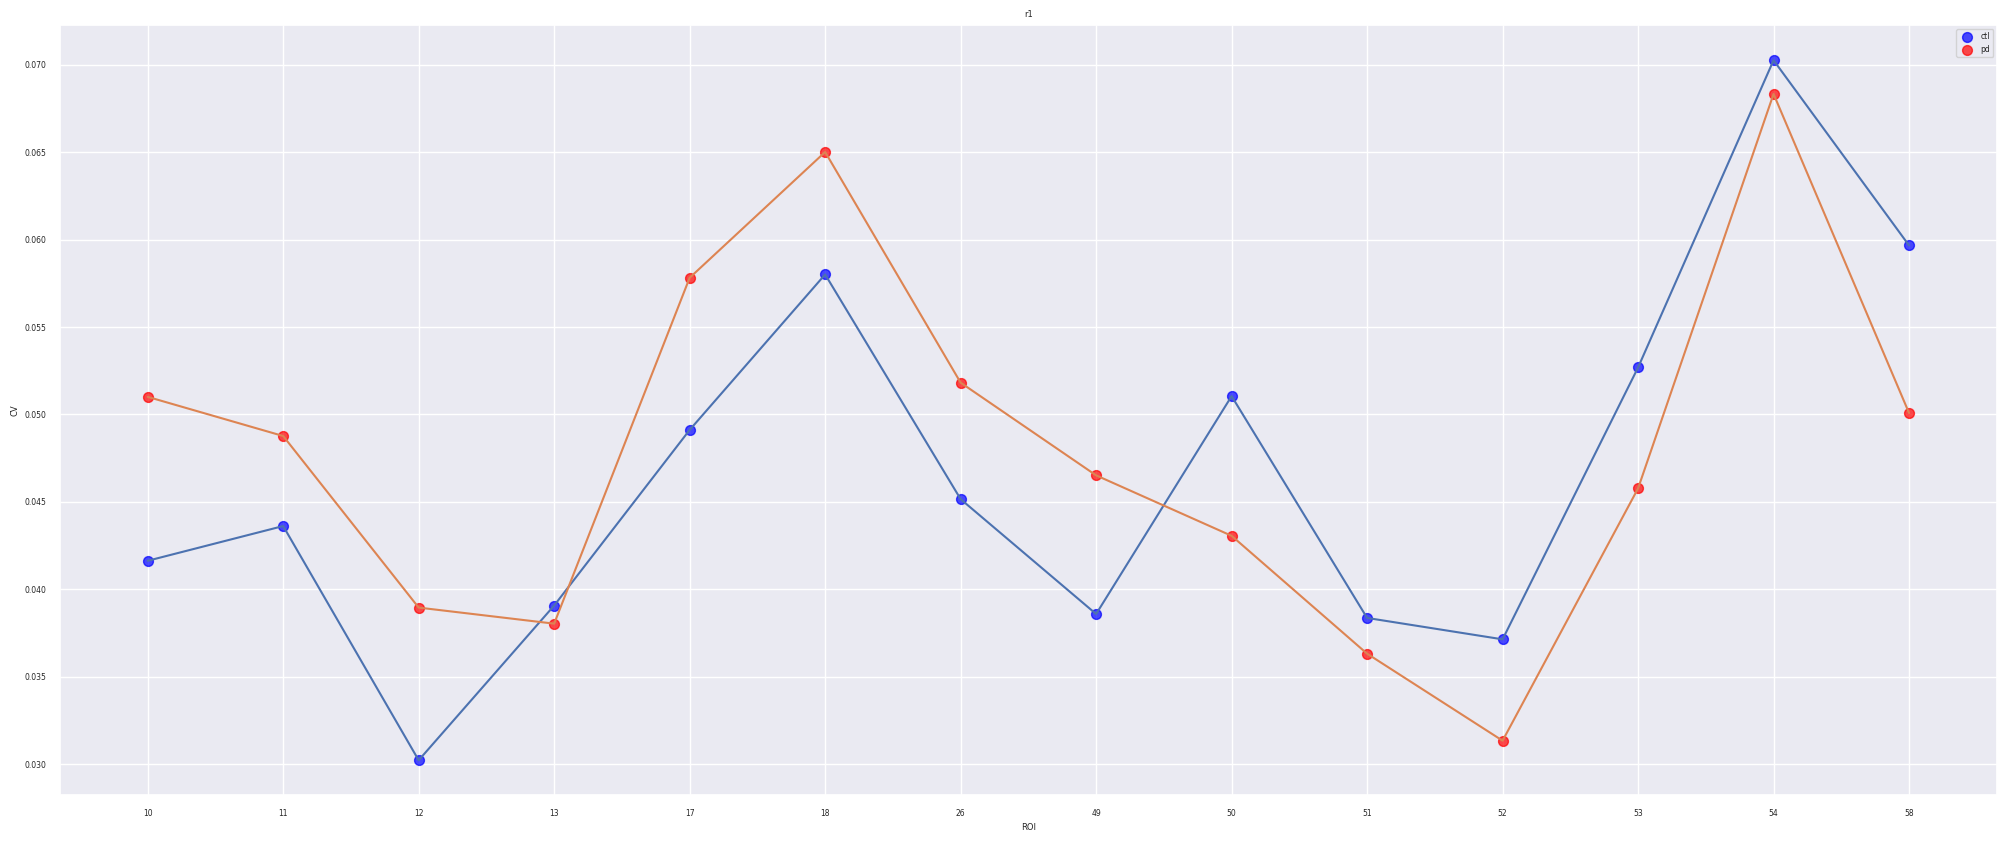

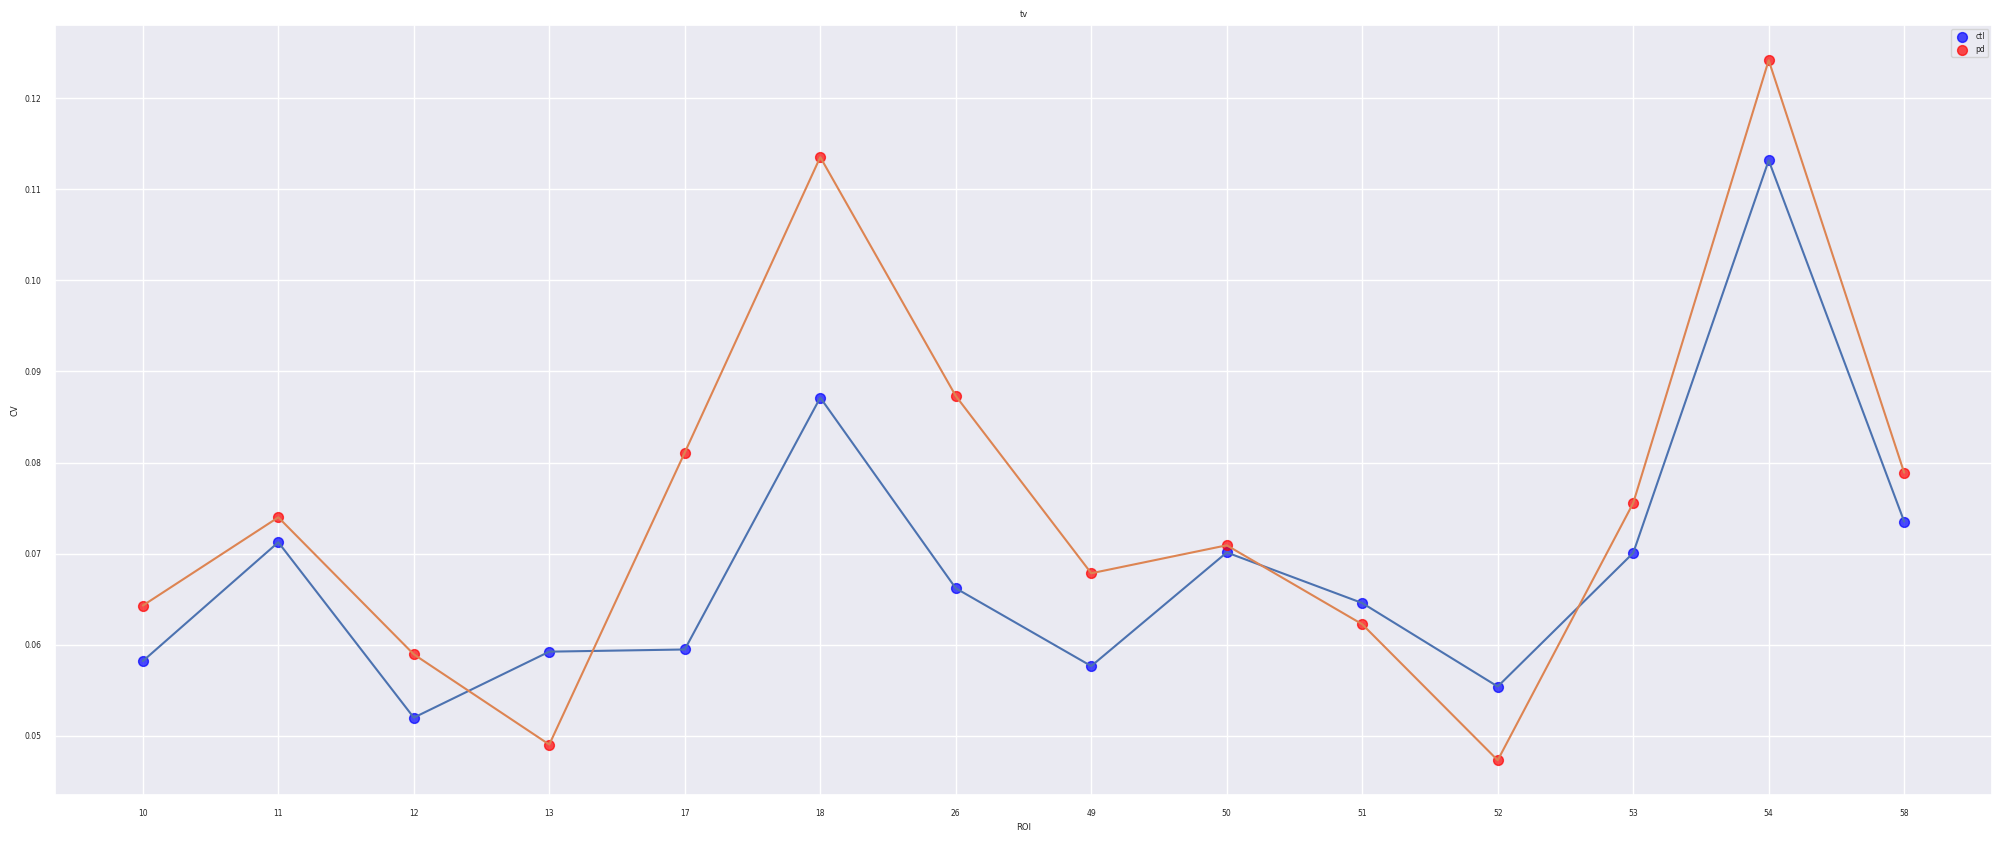

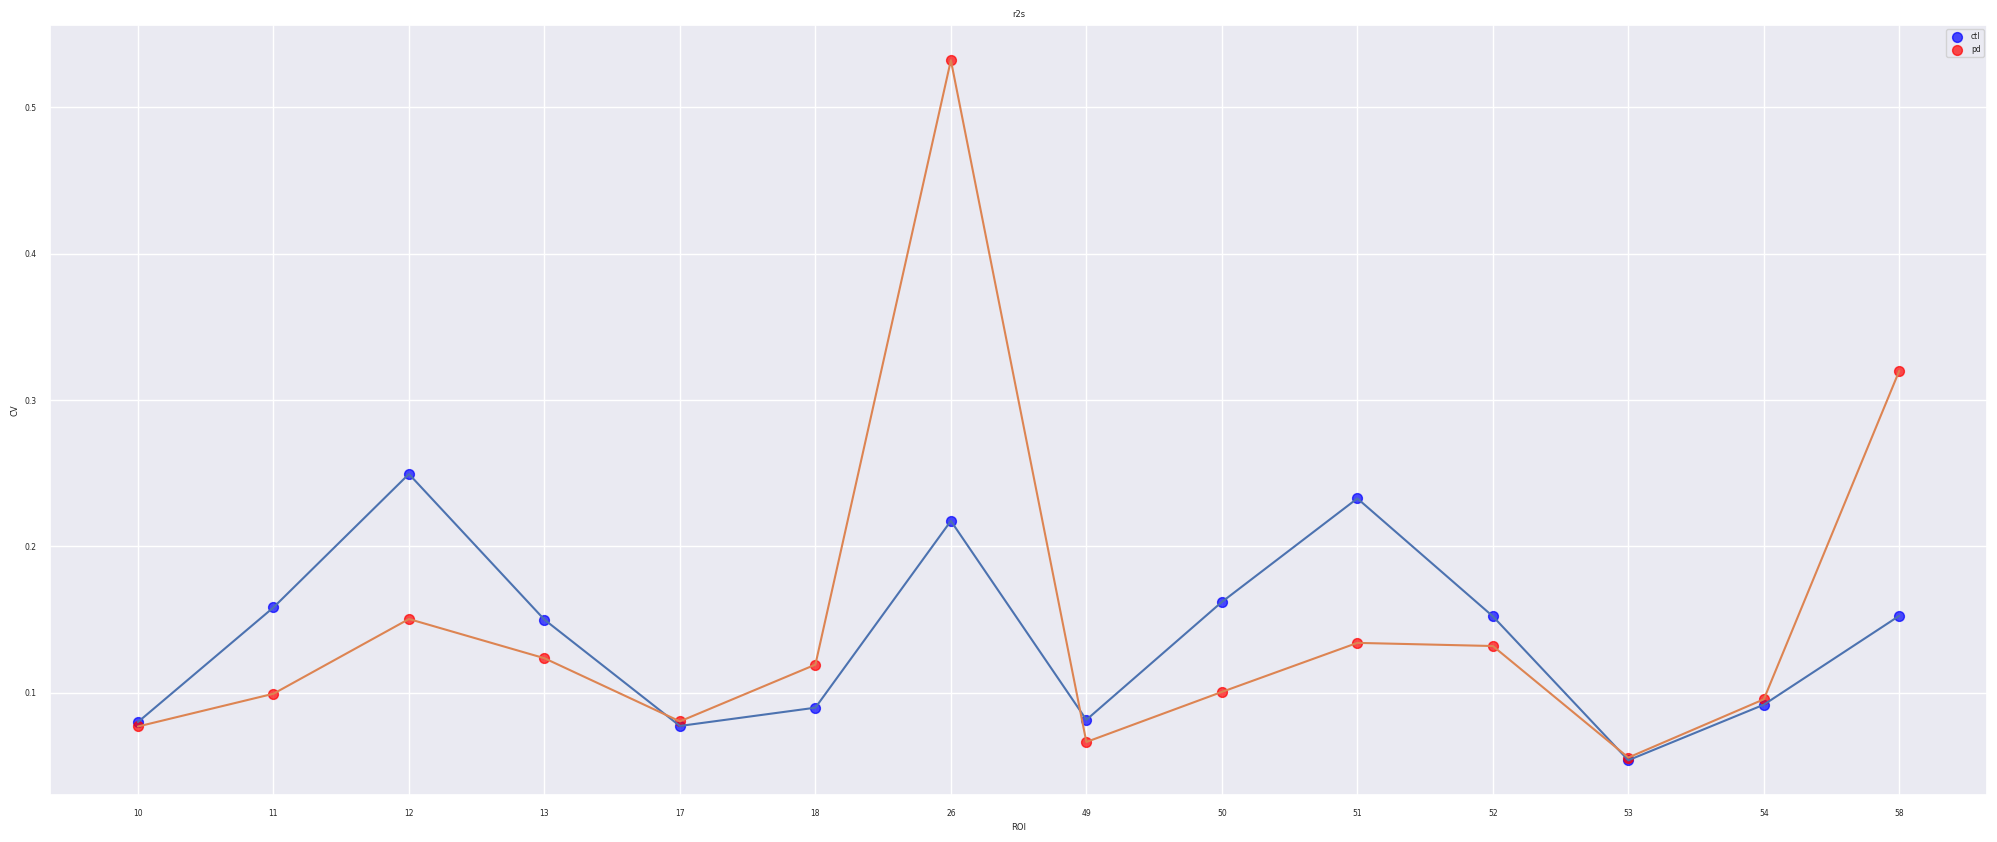

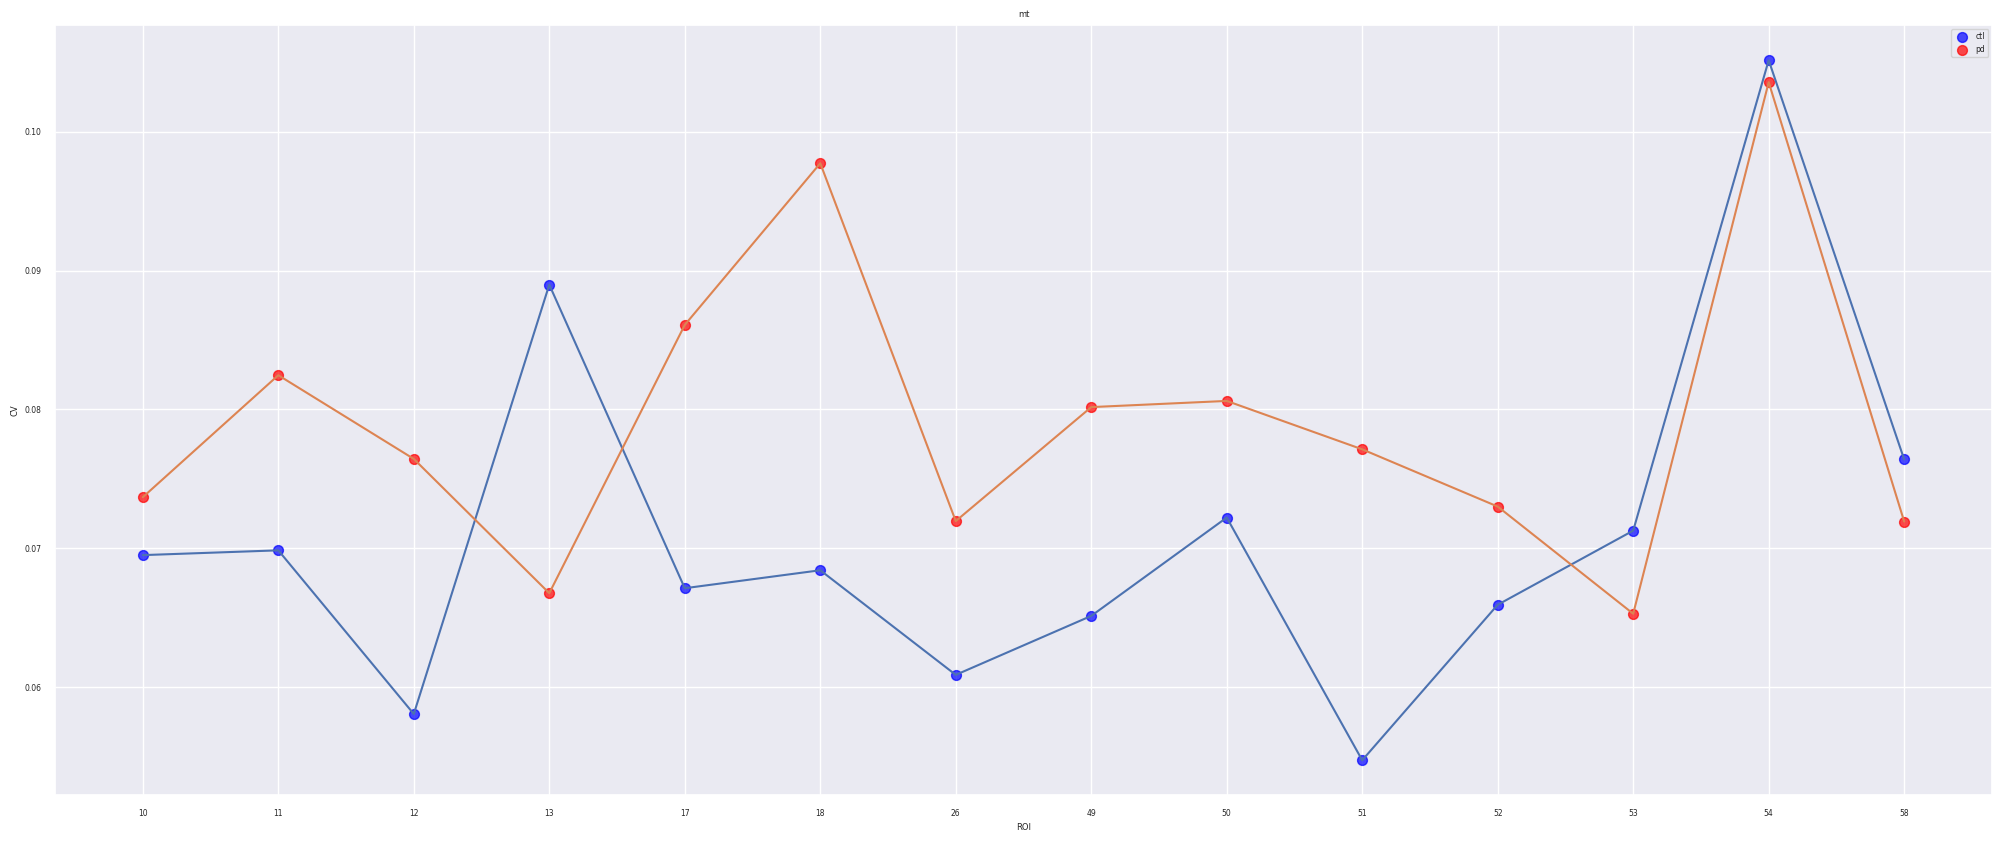

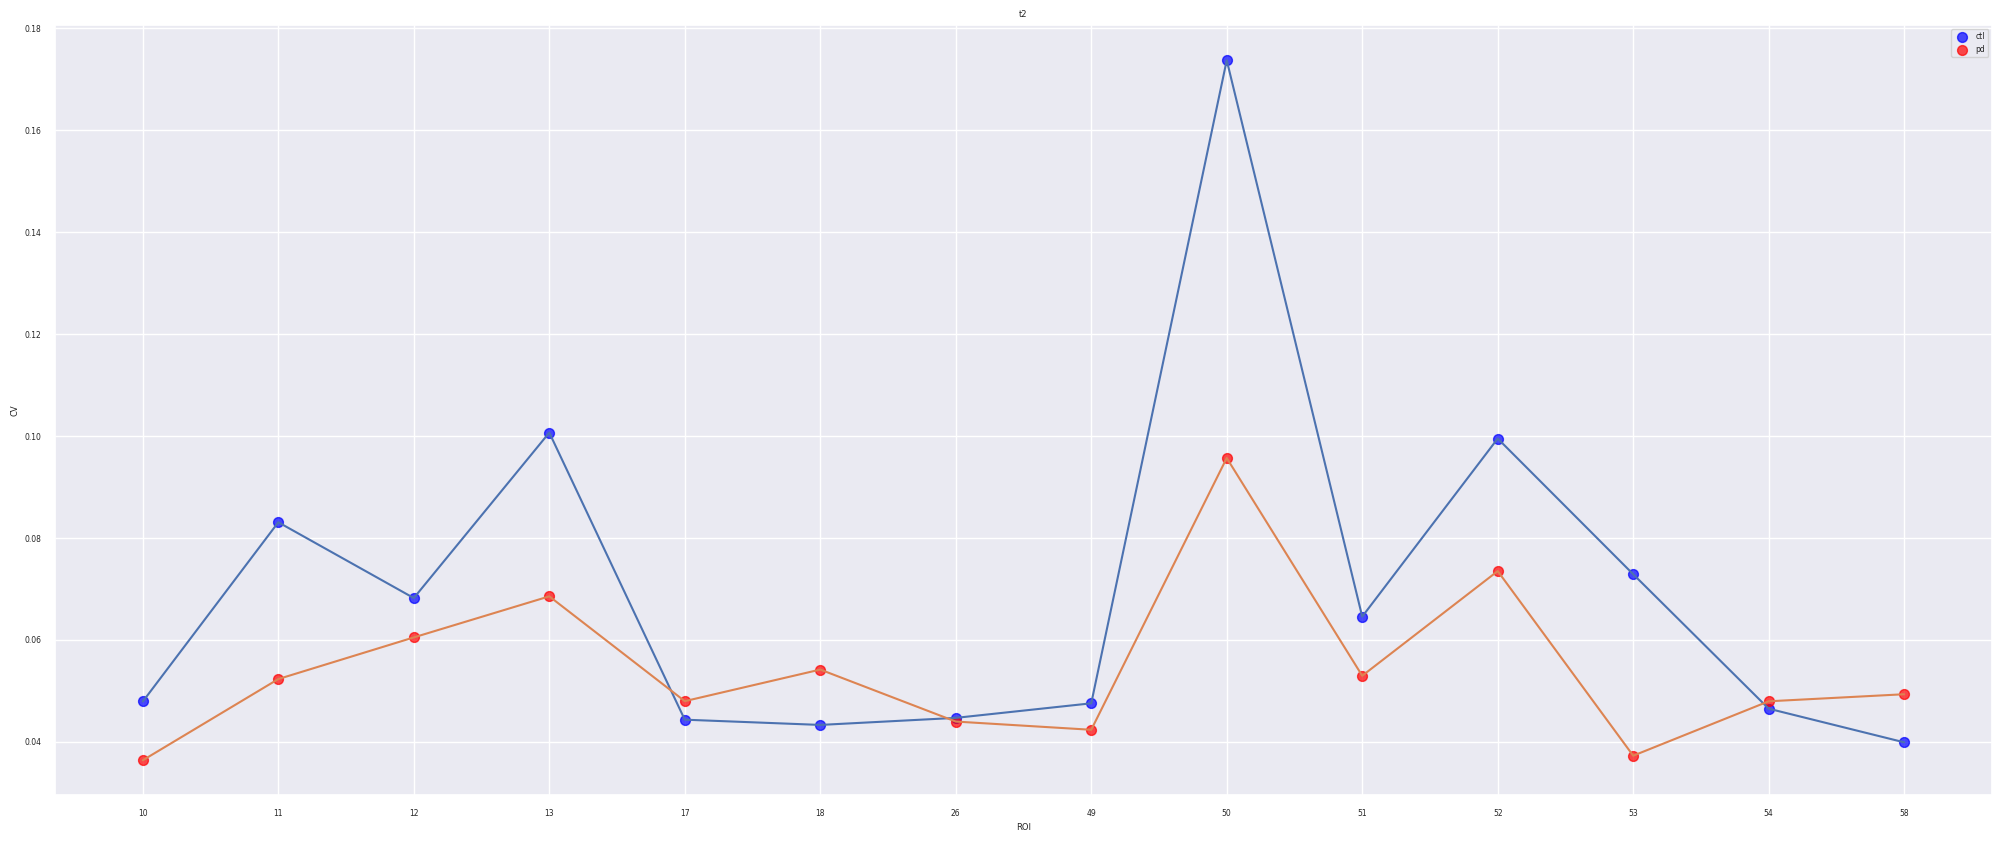

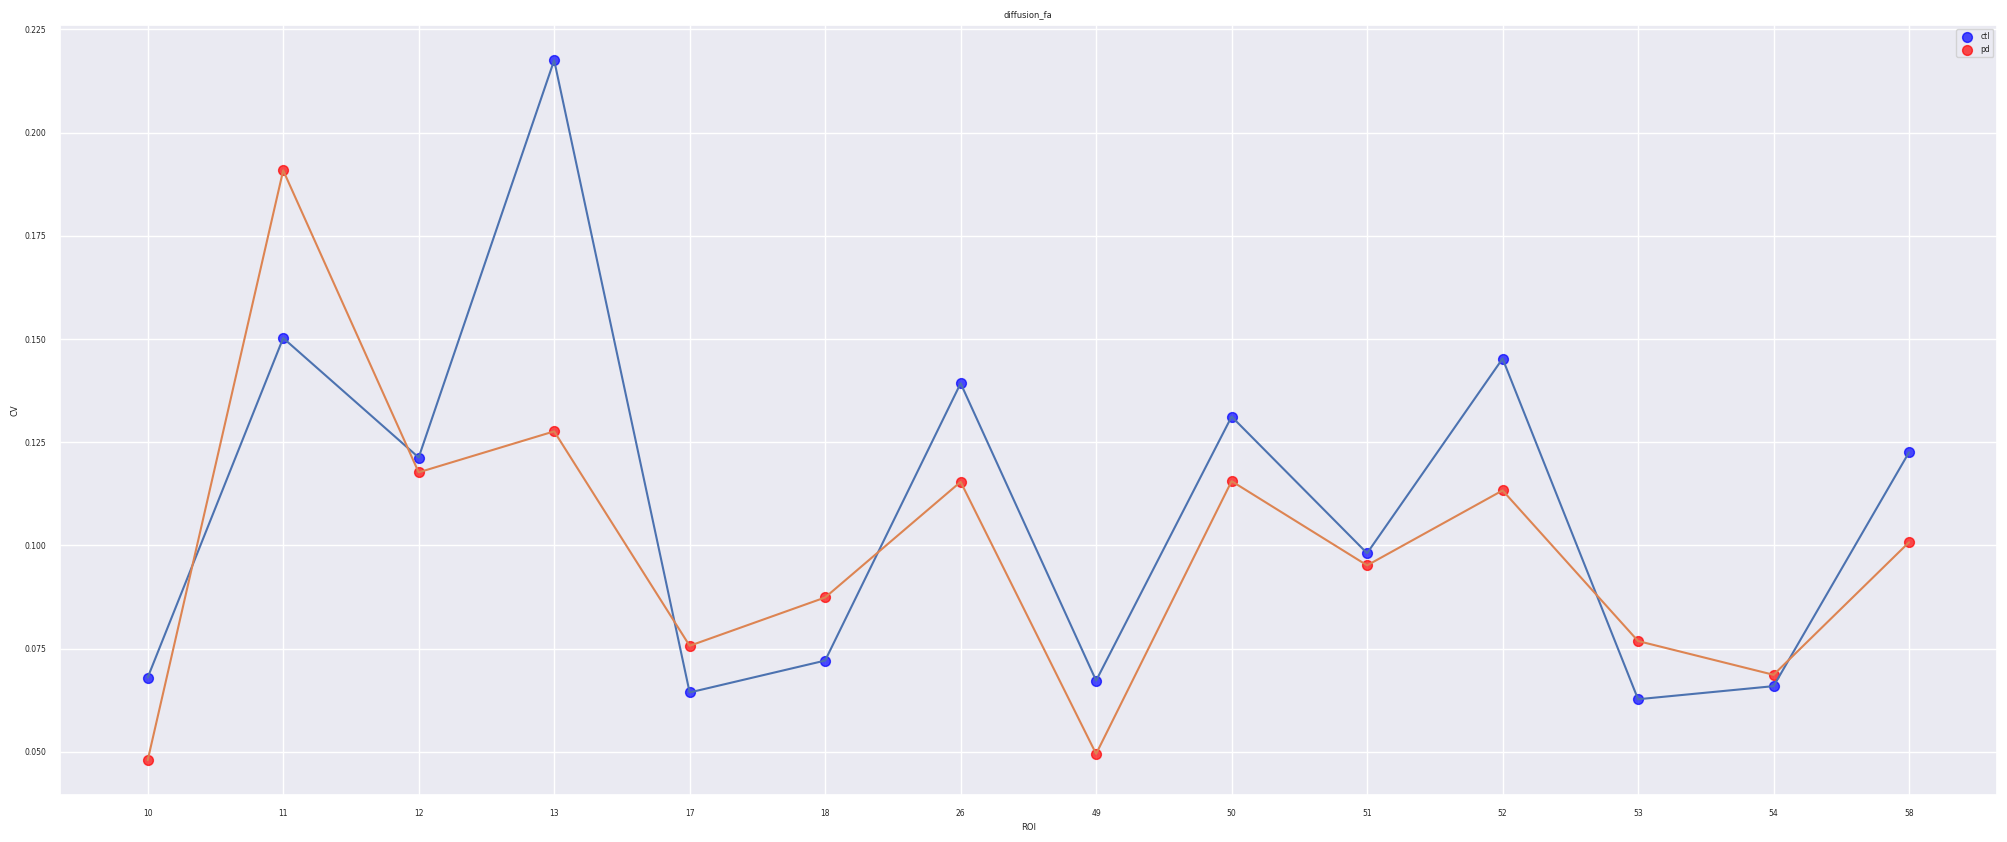

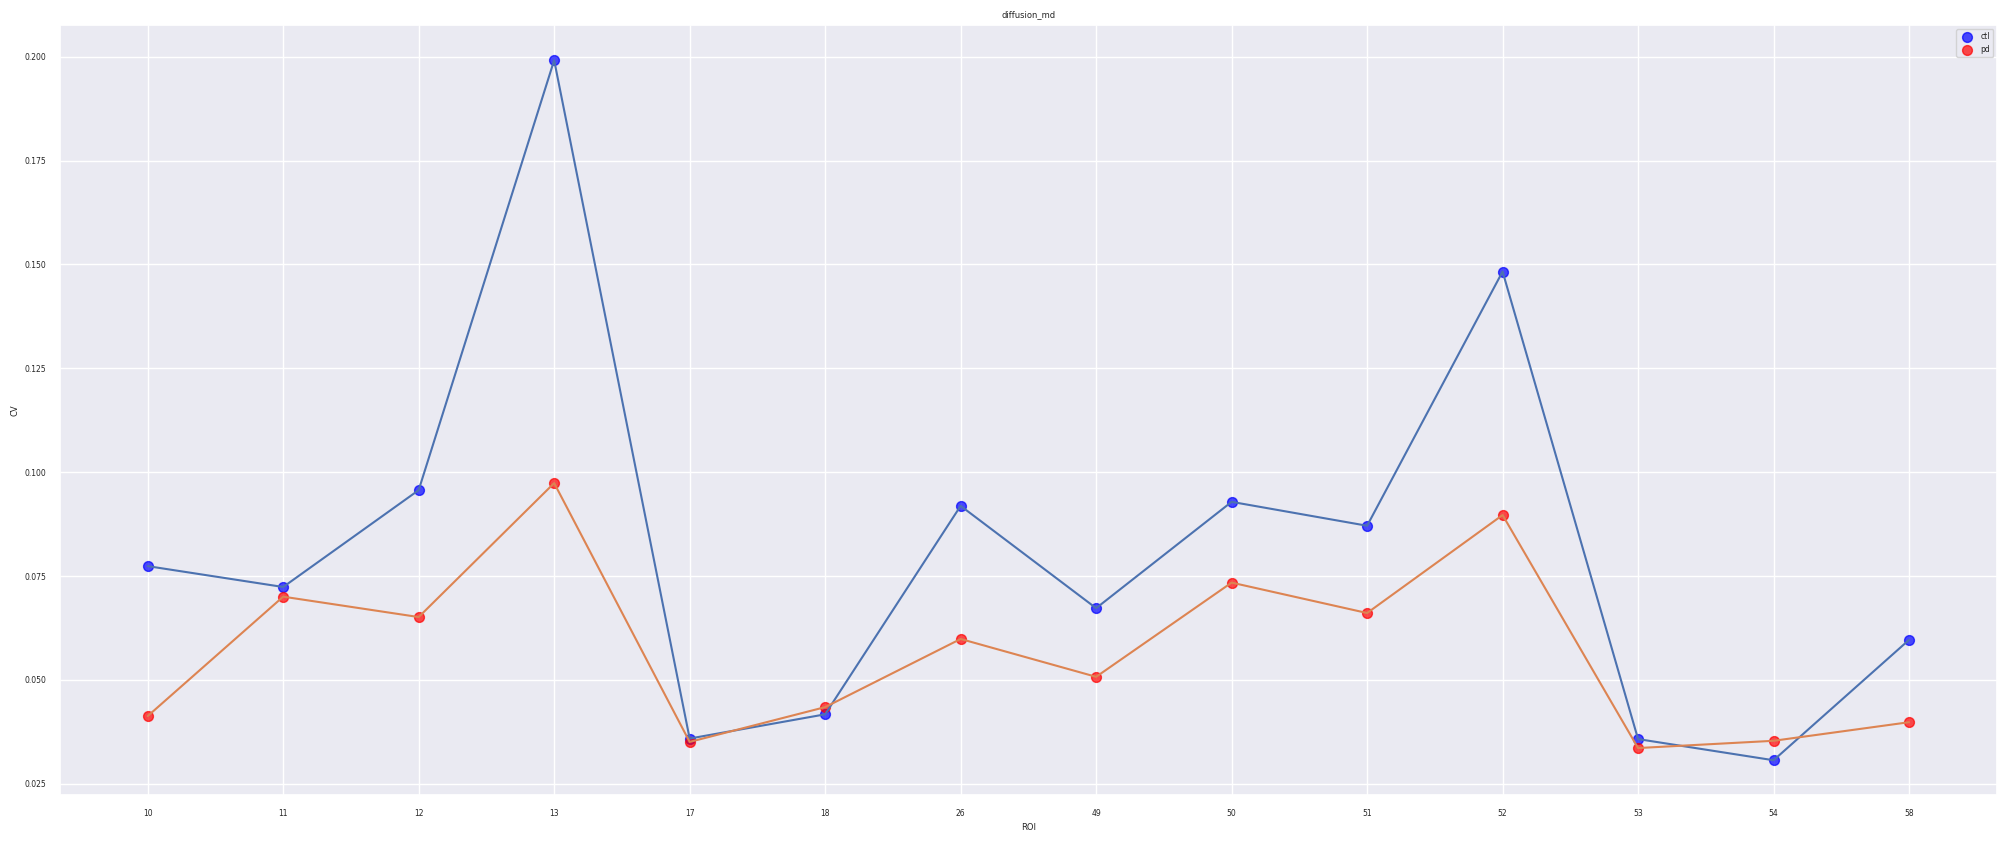

In [29]:
group_by_param = 'ROI'
x_axis = 'ROI'
data_groups = [(ctl_subjects_raw, 'blue', 'ctl'), (pd_subjects_raw, 'red', 'pd')]
StatisticsWrapper.calculate_cv_for_subjects(data_groups, group_by_param, params_to_work_with, x_axis, use_reg=False, fig_size=(25, 10), connect_scatter=True)

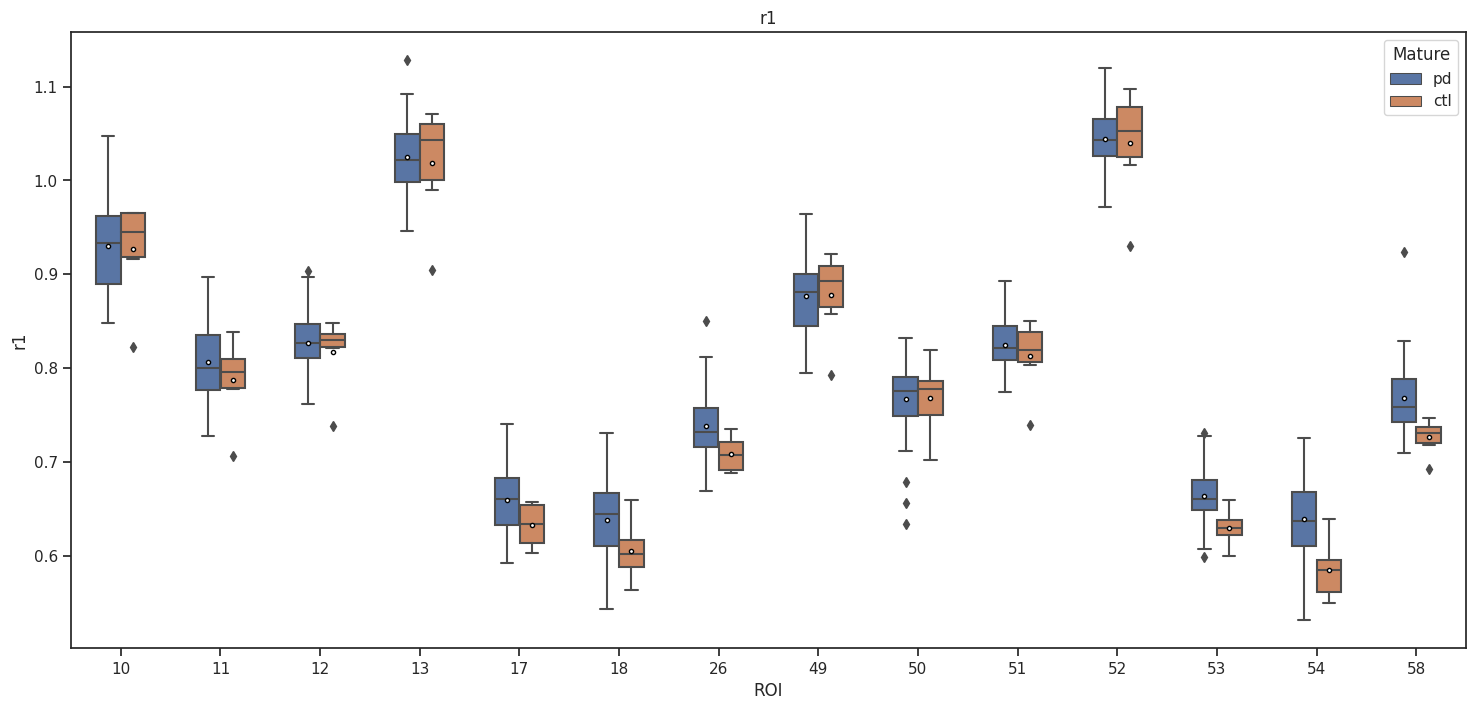

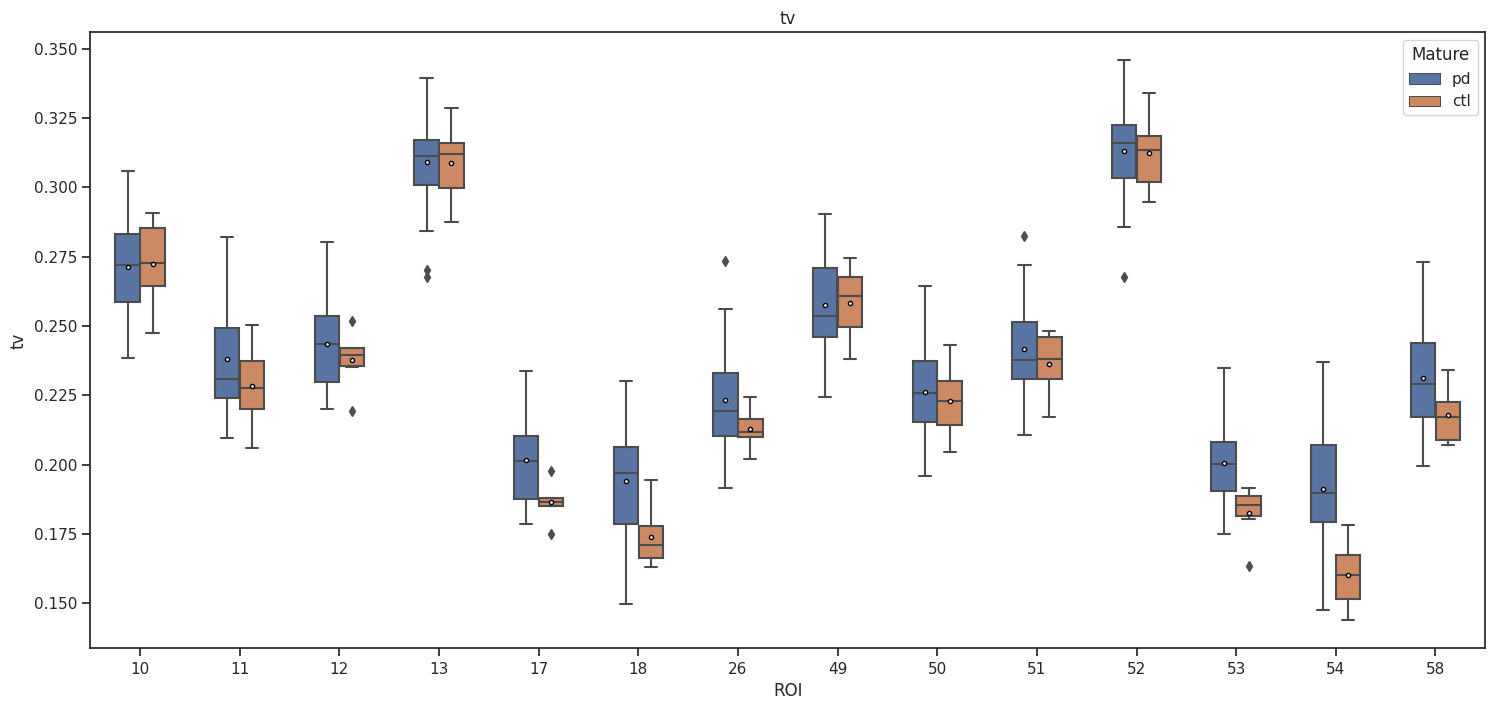

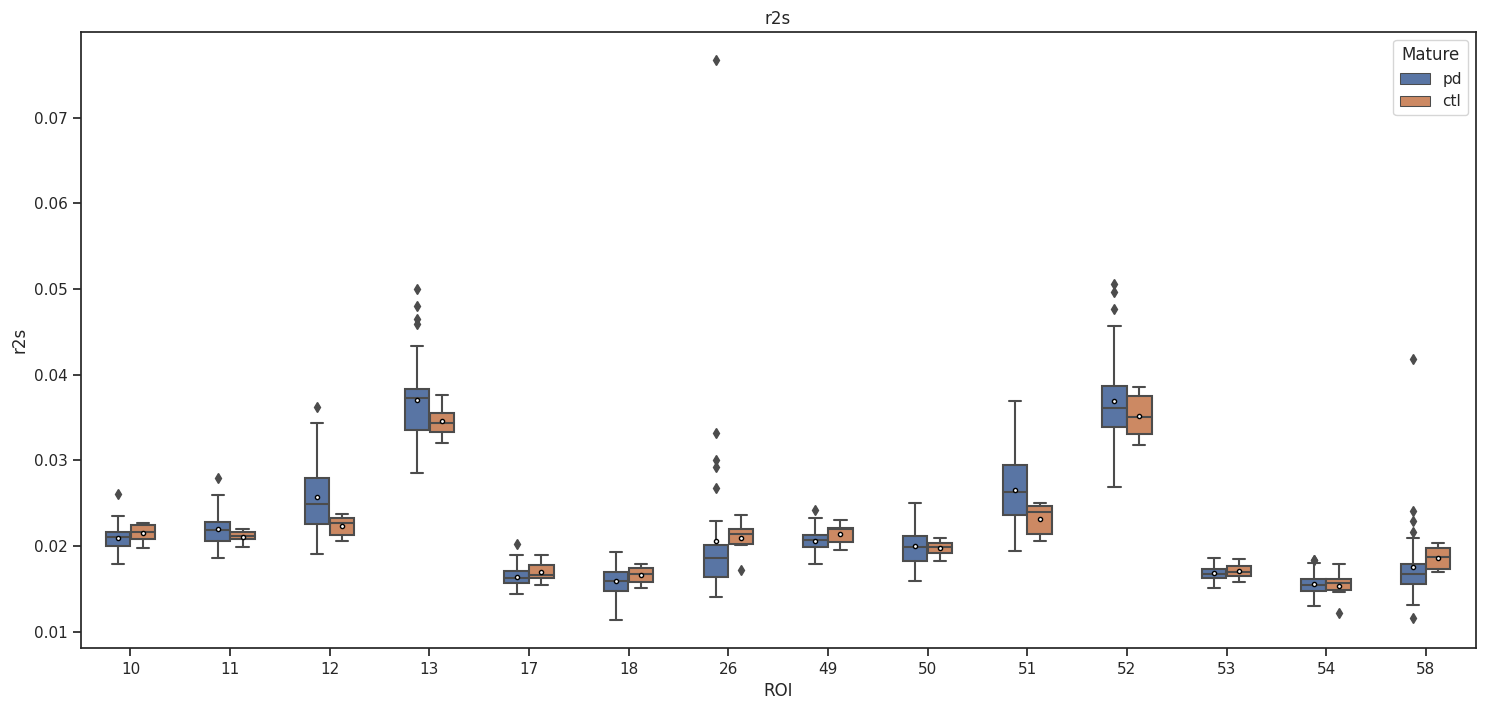

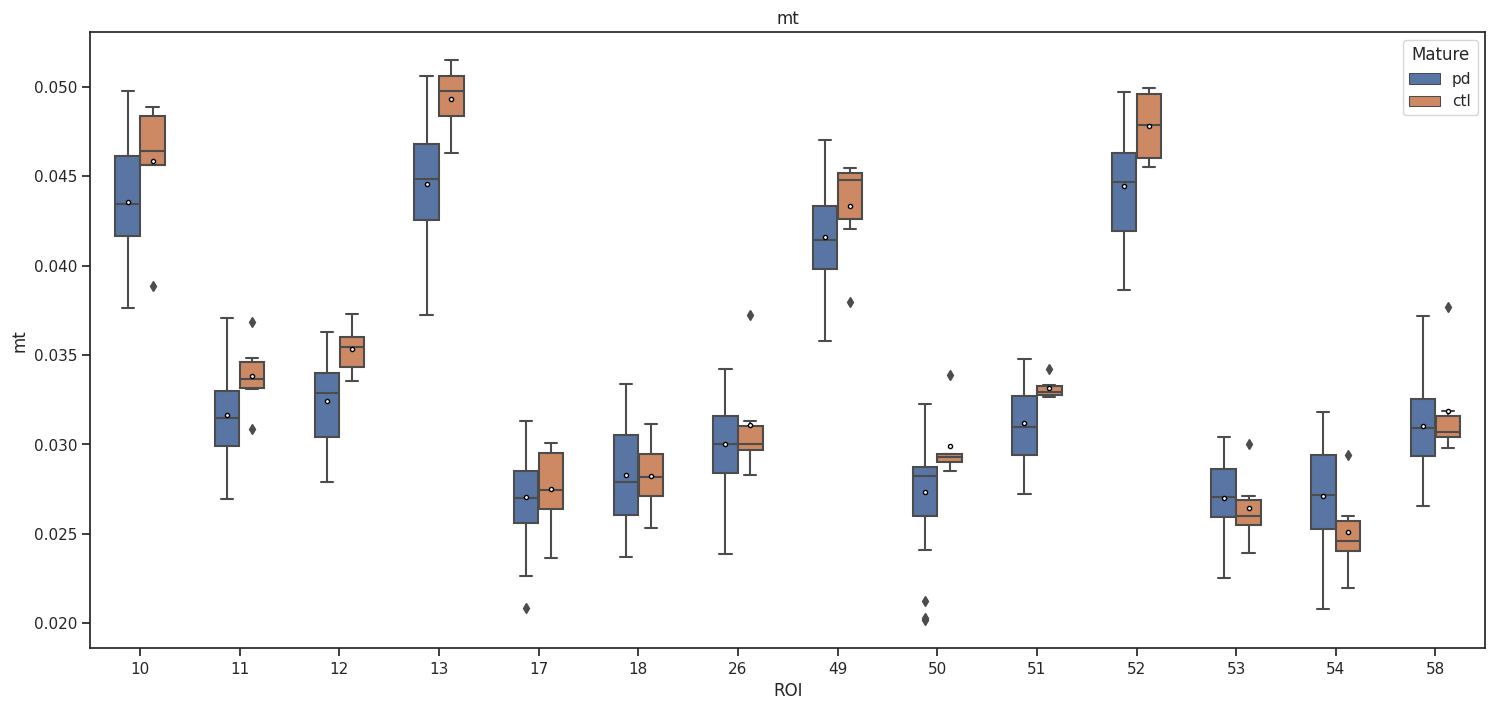

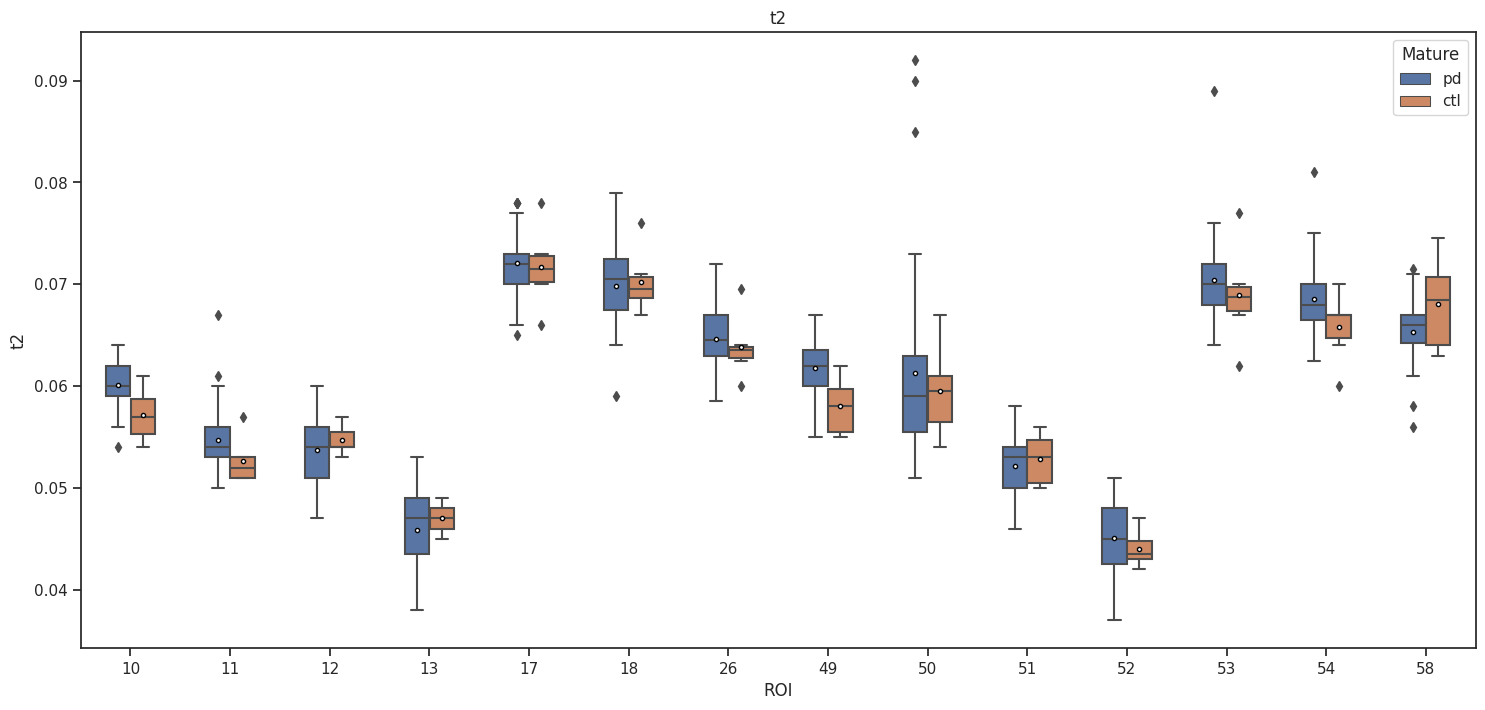

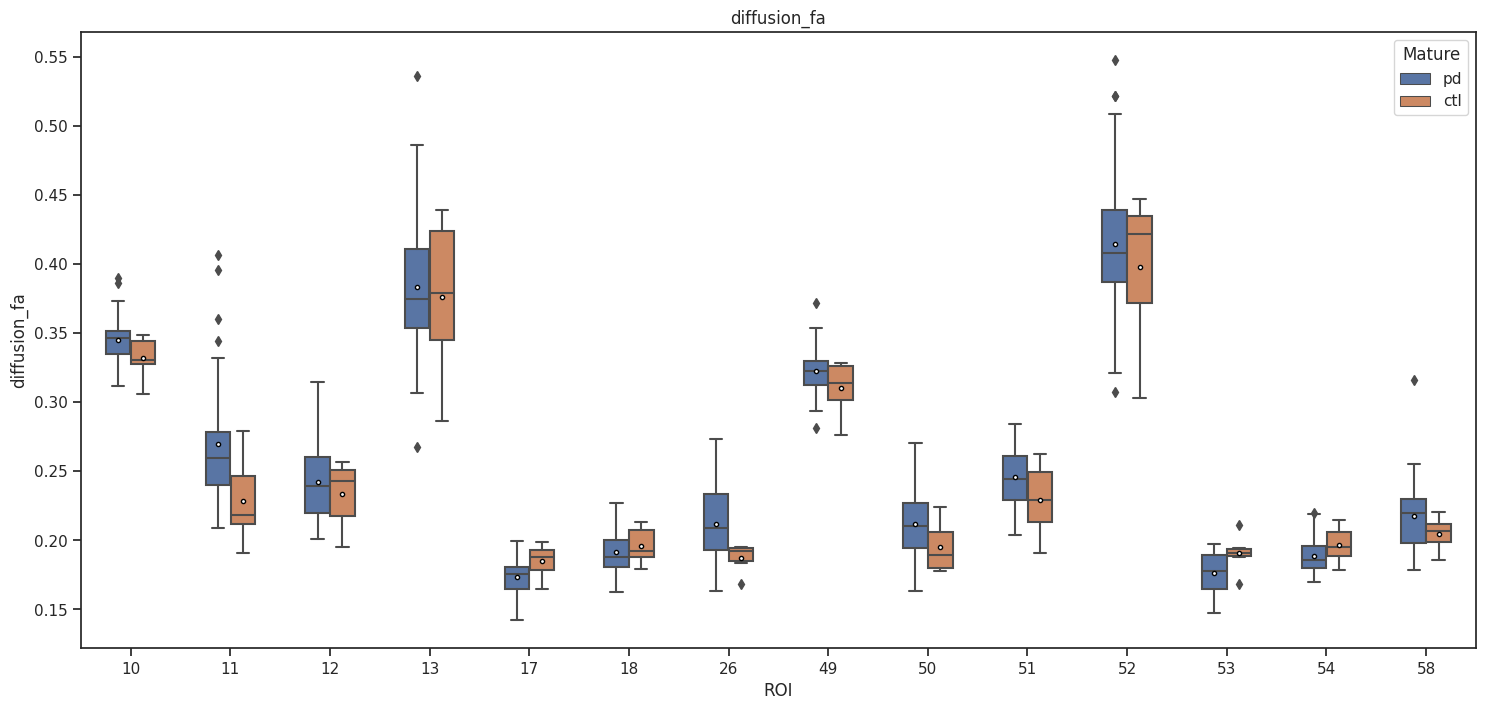

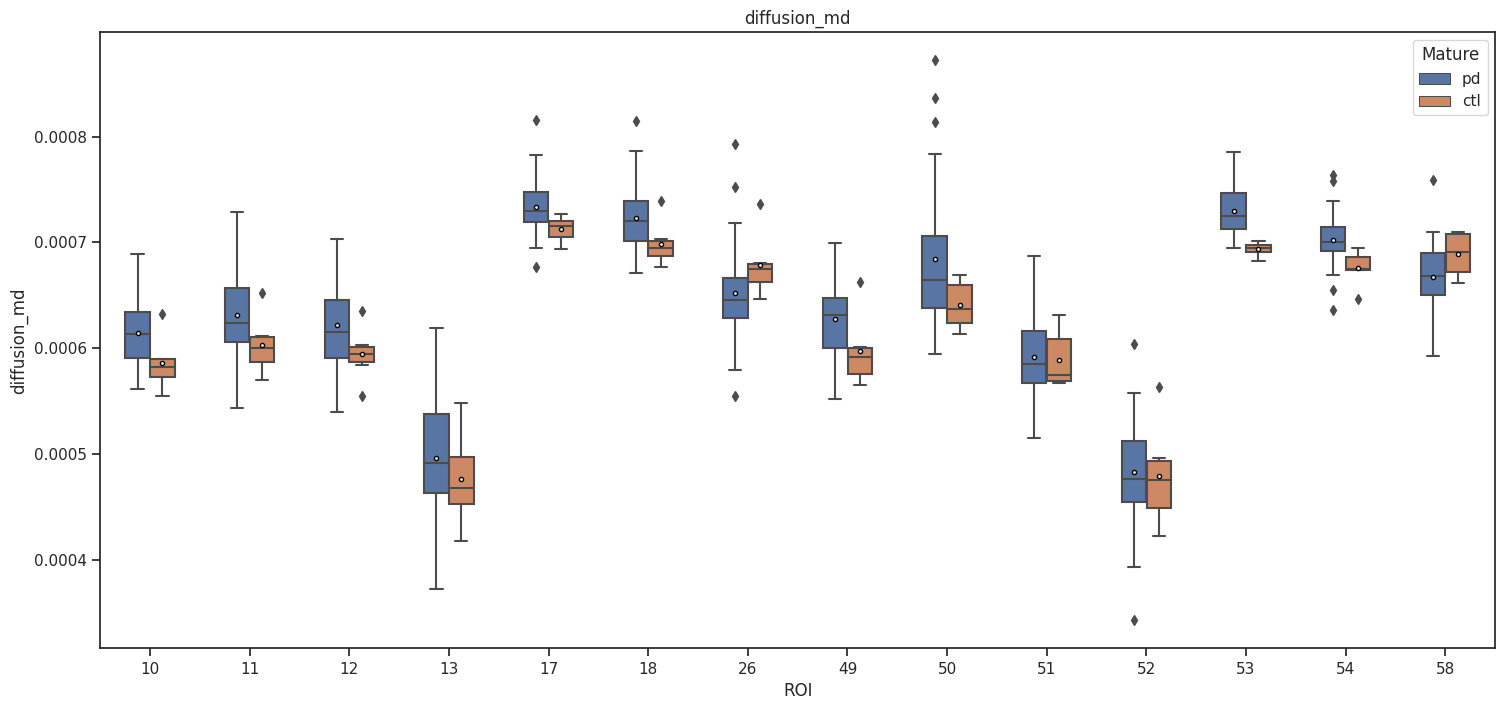

In [13]:
%autoreload 2
StatisticsWrapper.plot_data_per_param_per_roi_next_to_each_other(ctl_subjects_raw, pd_subjects_raw,
                                                                            params_to_work_with,
                                                                            'ctl', 'pd')

## Check correlations on the normalized data

In [14]:
def show_correlations_stats(all_data, ctl_data, pd_data, method):
    clusters_rois = StatisticsWrapper.hierarchical_clustering(all_data, params_to_work_with, 'single',
                                                                title="all")['dendrogram_data']['ivl']
    ctl_result = StatisticsWrapper.roi_correlations(ctl_data, params_to_work_with, clusters_rois,
                                                        group_title='Correlations of ctl group', method=method)
    pd_result = StatisticsWrapper.roi_correlations(pd_data, params_to_work_with, clusters_rois,
                                                     group_title='Correlations of pd group', method=method)

    ctl_std_result = StatisticsWrapper.roi_correlations_std(ctl_data, params_to_work_with, clusters_rois,
                                                        title='Stds of Correlations of ctl group', method=method)
    pd_std_result = StatisticsWrapper.roi_correlations_std(pd_data, params_to_work_with, clusters_rois,
                                                             title='Stds of Correlations of pd group', method=method)
                        
    PlotsManager.plot_heatmap(pd_result - ctl_result, 'differences of pd and ctl', project_name=None)
    ctl_corr_means, pd_corr_means  = show_corr_mean(ctl_result, pd_result, clusters_rois)

    # PlotsManager.plot_colors_on_brain(ctl_data.subjects.iloc[0], ctl_corr_means, chosen_rois_dict, 'ctl_corr', 'heat')
    # PlotsManager.plot_colors_on_brain(ctl_data.subjects.iloc[0], pd_corr_means, chosen_rois_dict, 'pd_corr', 'heat')

def show_corr_mean(ctl_result, pd_result, clusters_rois):
    ctl_result['corr_mean'] = ctl_result.apply(np.mean, axis=1) - 1/ctl_result.shape[0]
    pd_result['corr_mean'] = pd_result.apply(np.mean, axis=1) - 1/pd_result.shape[0]

    fig = plt.figure(figsize=(20, 8))
    ax = fig.add_subplot(1, 1, 1)
    ax.set_title('Average correlations')
    ax.scatter(clusters_rois, ctl_result['corr_mean'].to_numpy(), color='blue', s=20, alpha=0.7, label='ctl')
    ax.scatter(clusters_rois, pd_result['corr_mean'].to_numpy(), color='red', s=20, alpha=0.7, label='pd')

    # Connecting the points with vertical lines
    for x, y1, y2 in zip(clusters_rois, ctl_result['corr_mean'].to_numpy(), pd_result['corr_mean'].to_numpy()):
        plt.plot([x, x], [y1, y2], color='gray', linestyle='--')
        
    ax.set_facecolor('white')
    ax.legend()

    return ctl_result['corr_mean'], pd_result['corr_mean']


/ems/elsc-labs/mezer-a/niv.amos/repos/qMRI Analyzer - Code/statistics_methods/Statistics.py:534: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  clusters = linkage(distances, method=linkage_metric)


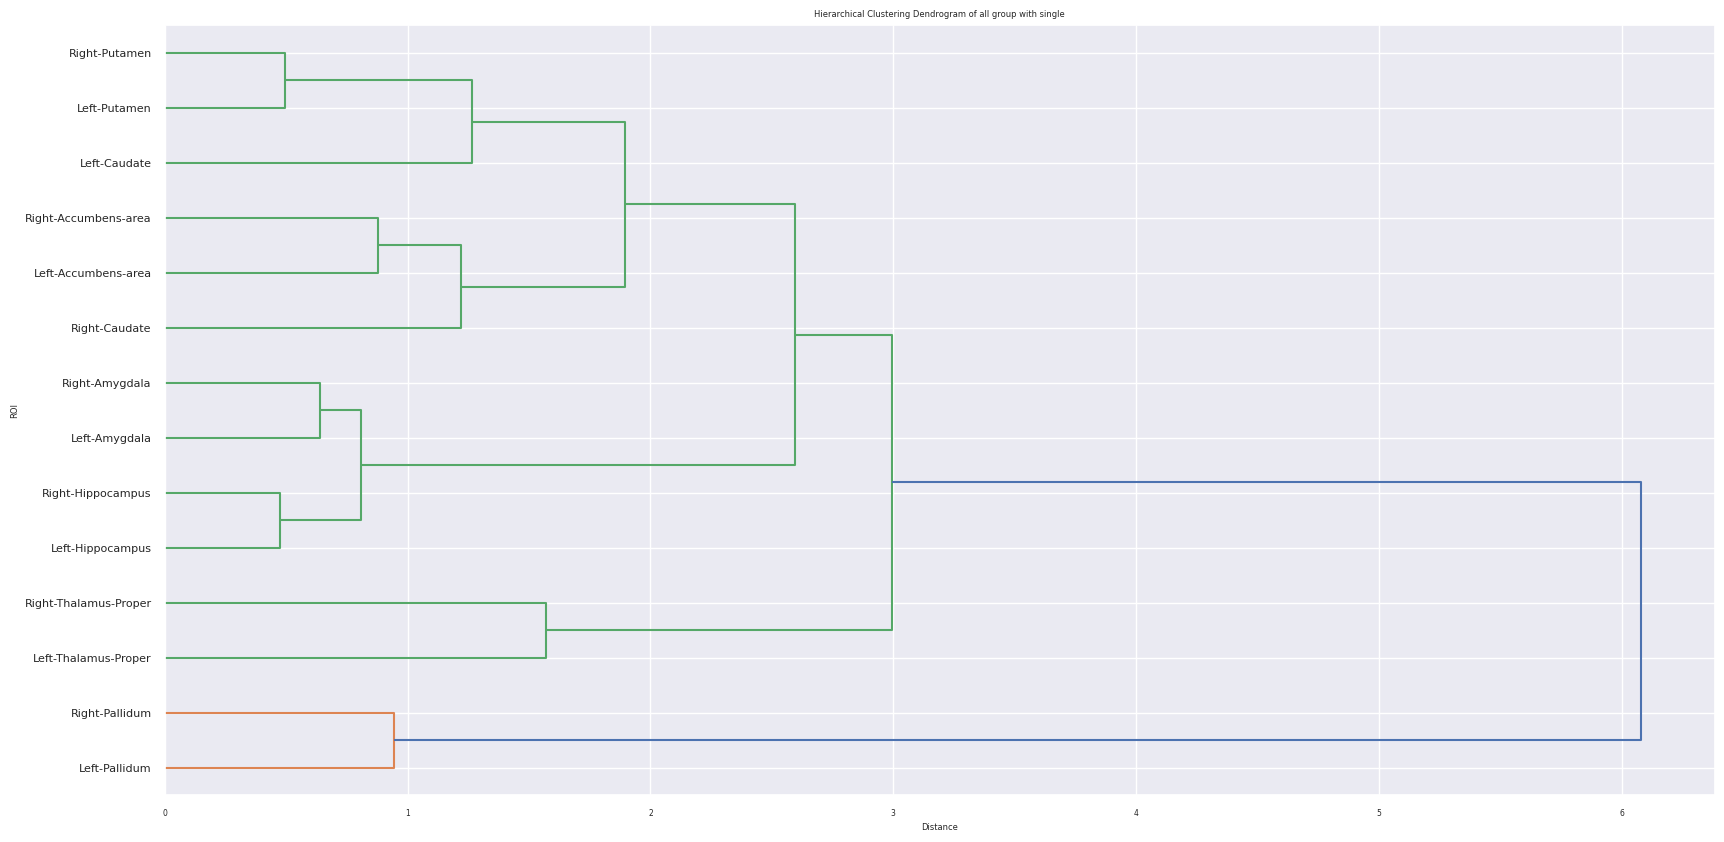

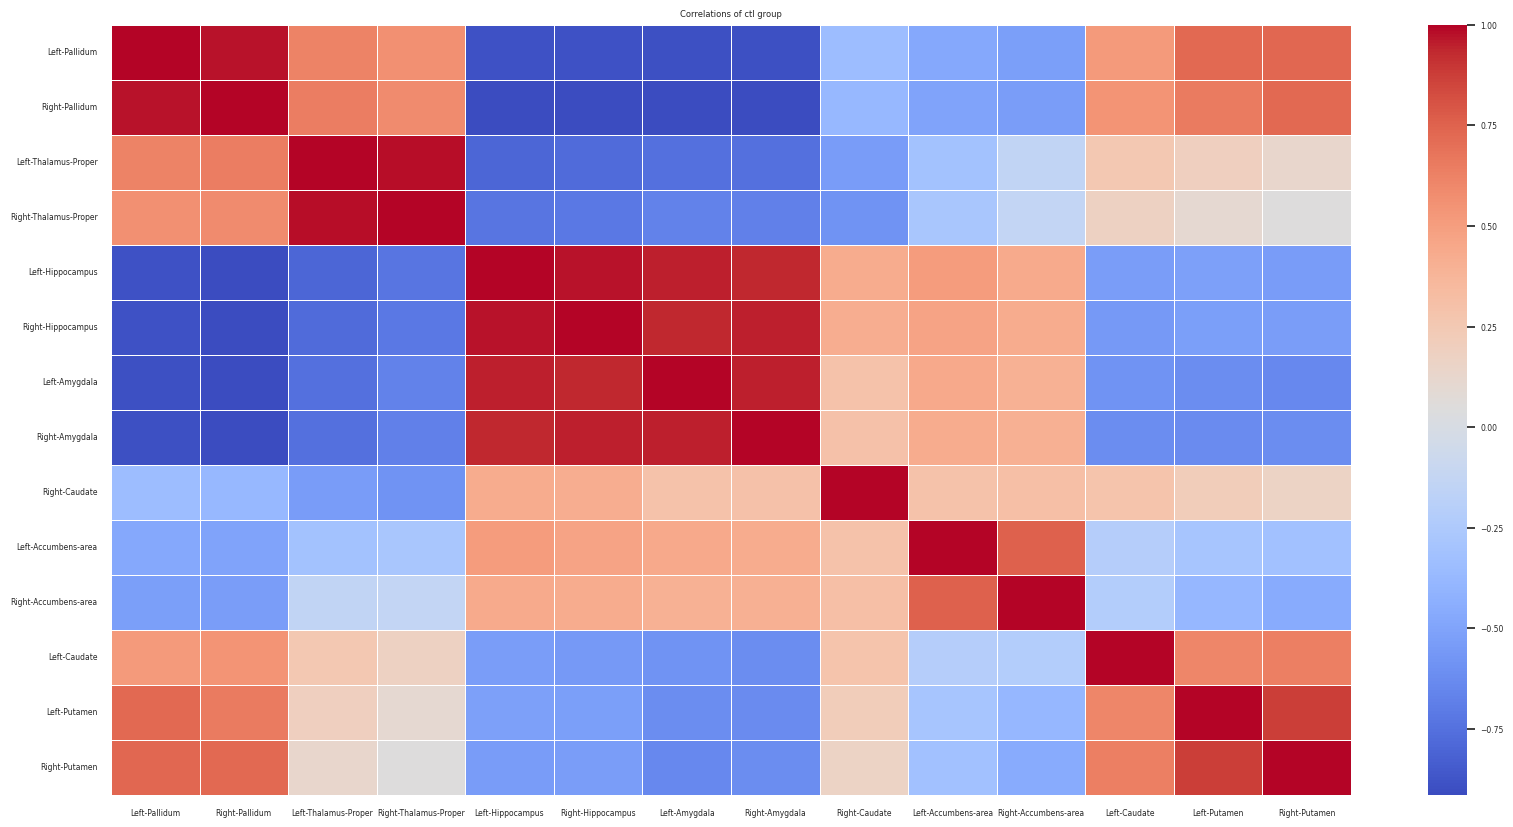

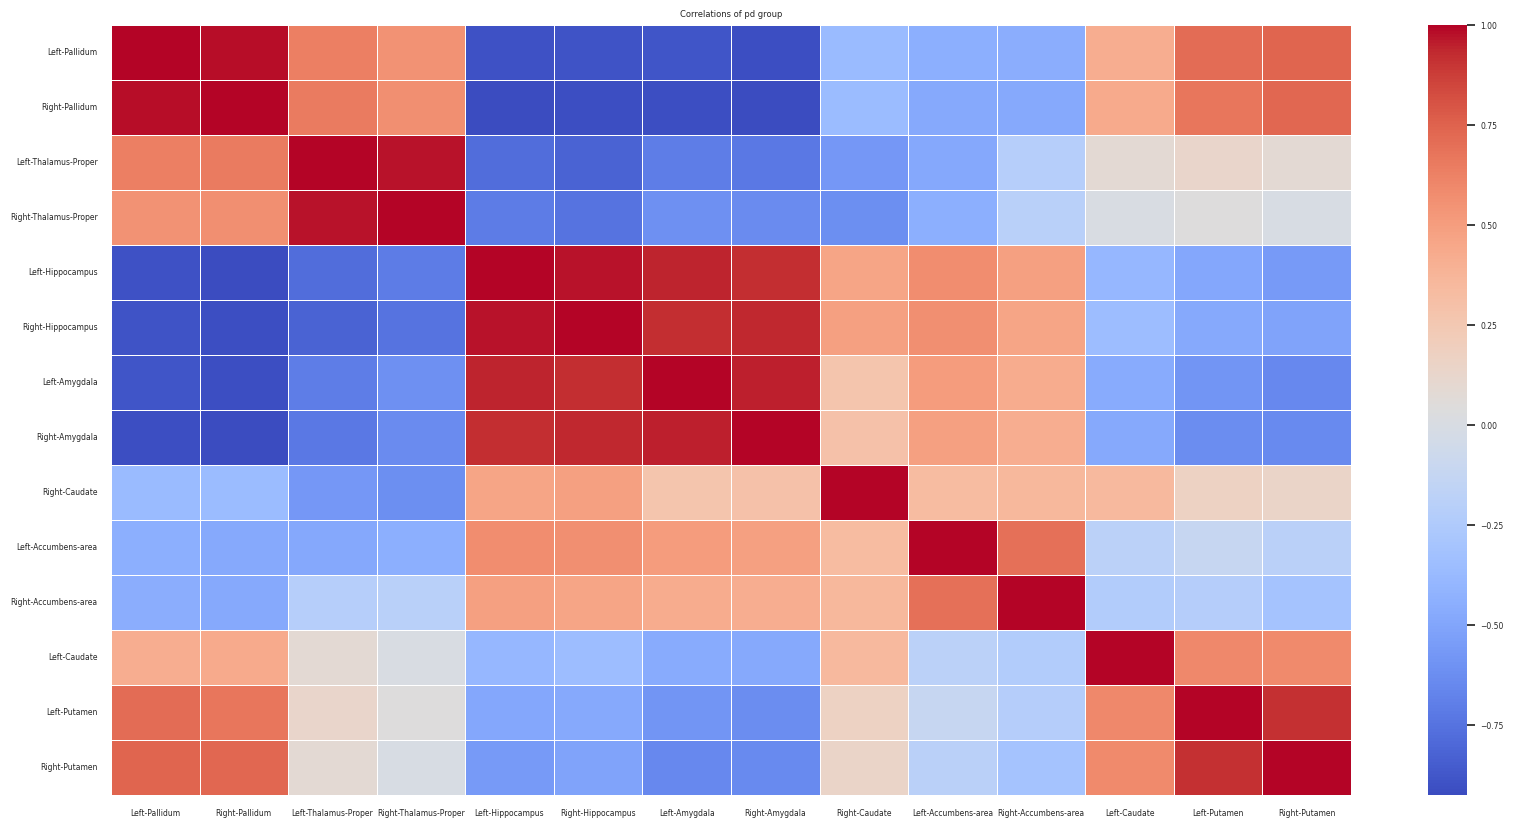

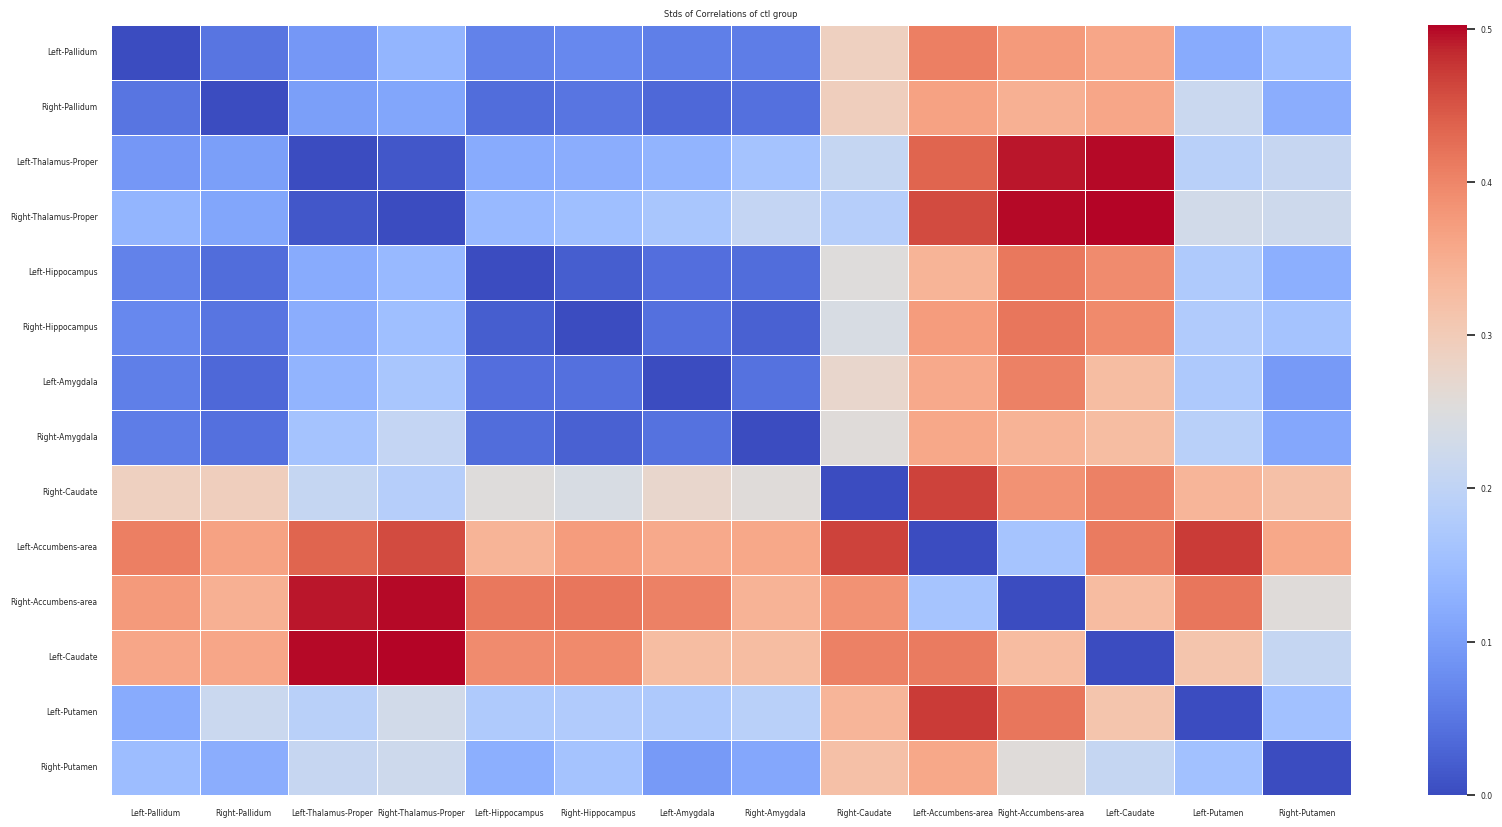

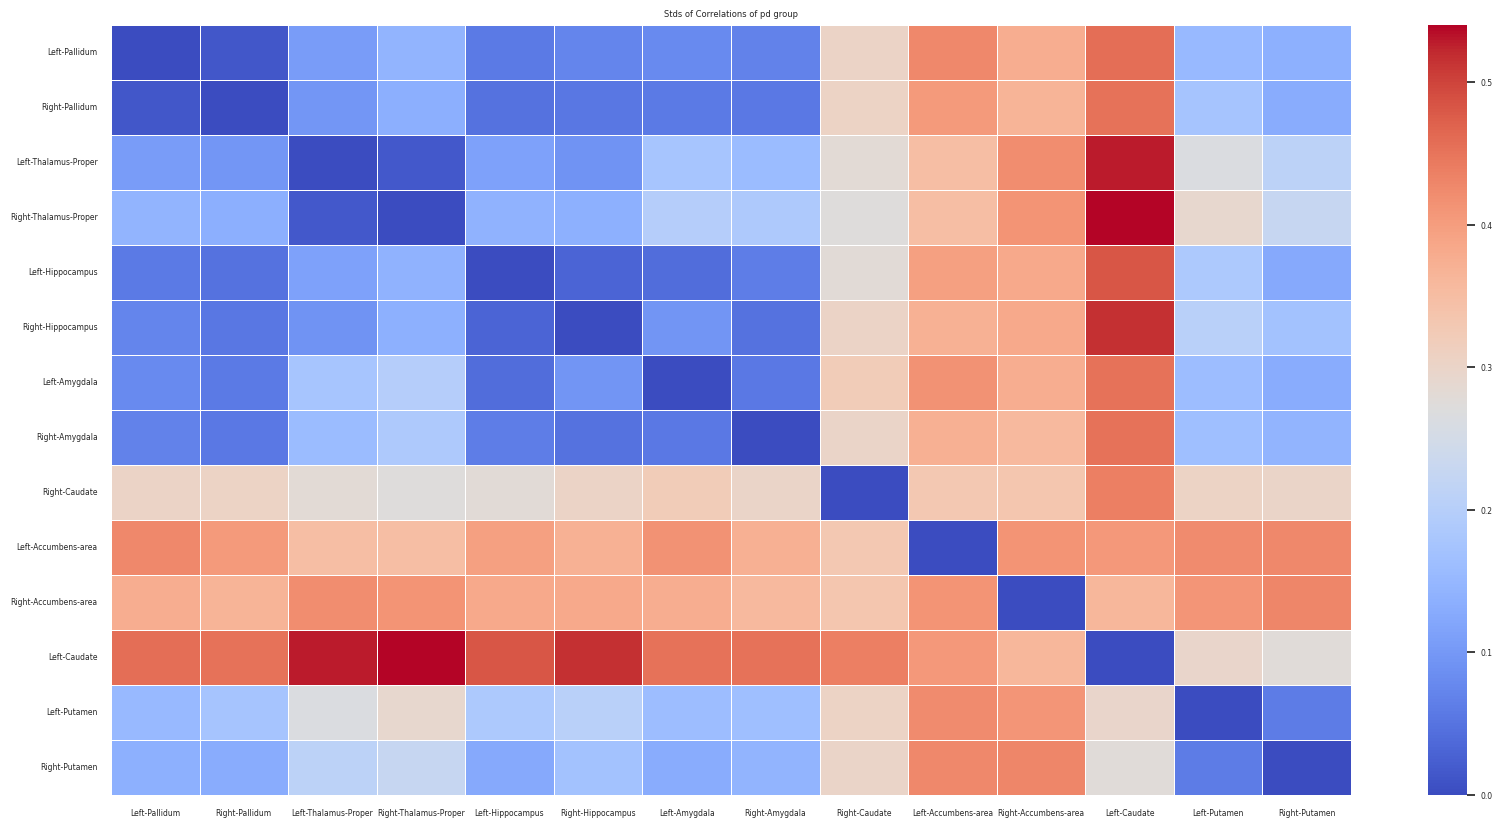

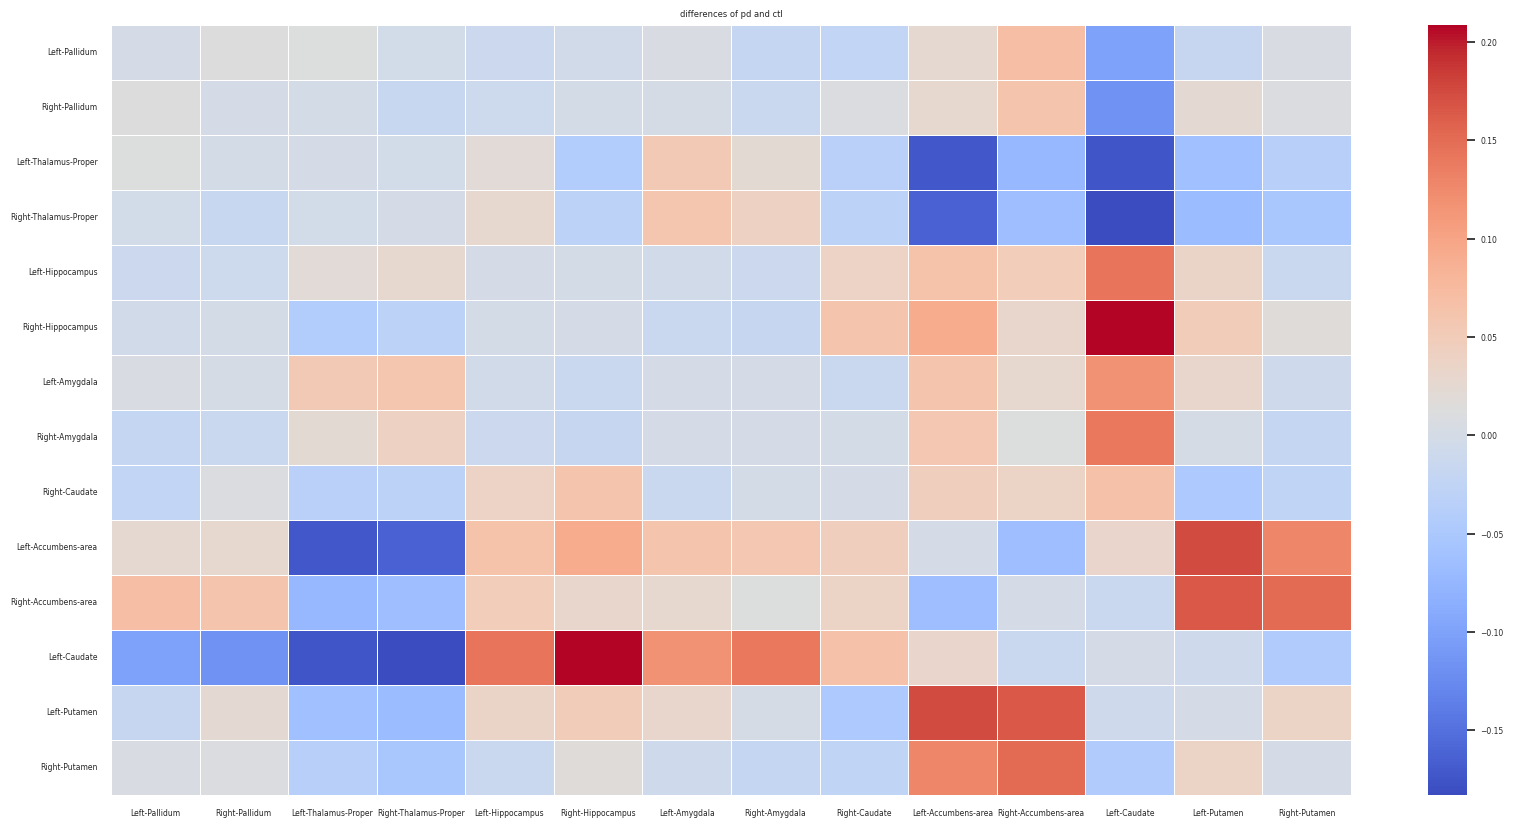

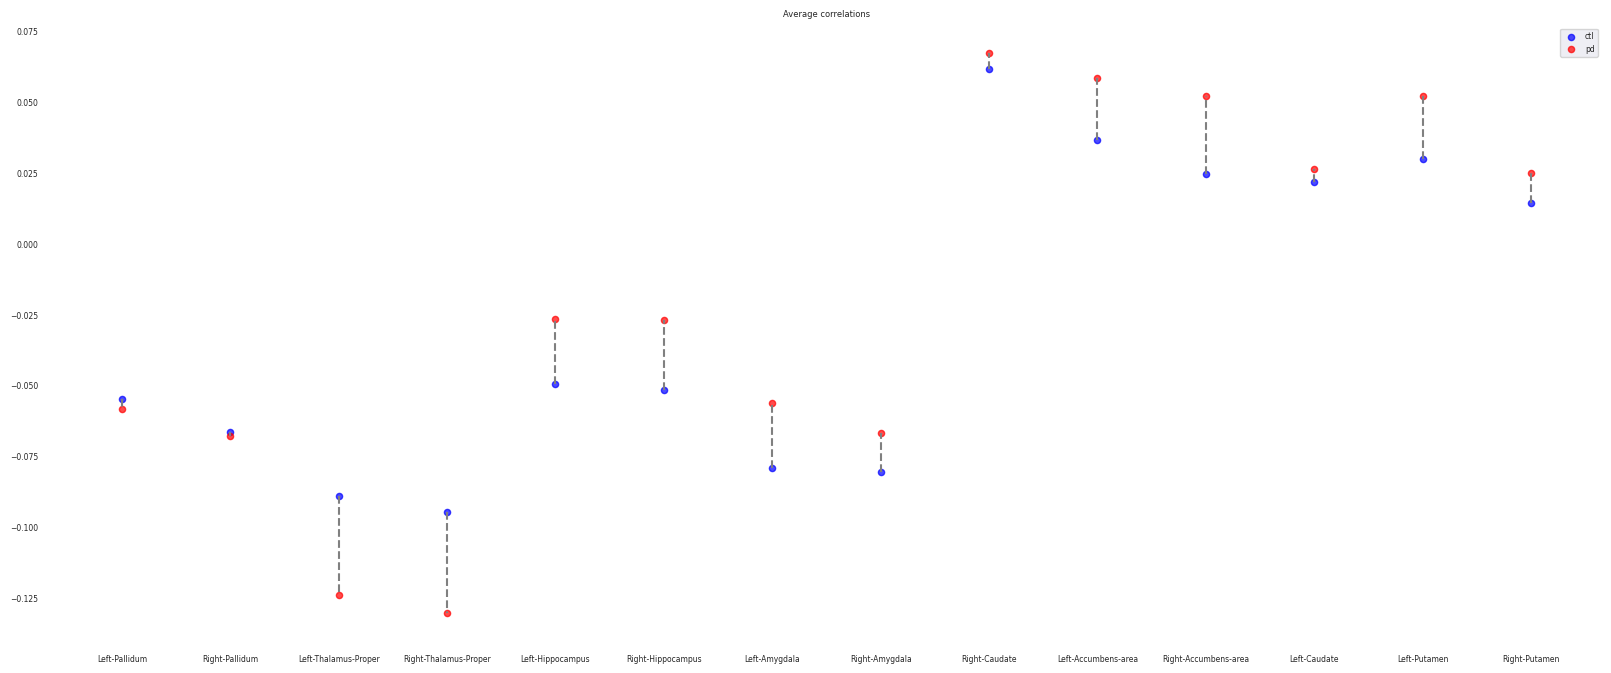

In [16]:
show_correlations_stats(chosen_data_z_score, ctl_subjects_z_score, pd_subjects_z_score, 'pearson')

Check t_test on the young and old groups

In [17]:
StatisticsWrapper.t_test_per_parameter_per_area(ctl_subjects_raw, pd_subjects_raw, chosen_rois_dict, 'ROI', params_to_work_with)

param r1 number of areas with significance differences: 0
param tv number of areas with significance differences: 3
param r2s number of areas with significance differences: 0
param mt number of areas with significance differences: 0
param t2 number of areas with significance differences: 3
param diffusion_fa number of areas with significance differences: 2
param diffusion_md number of areas with significance differences: 0


Subjects clustering 

In [18]:
def reduce_dim(model, data, drop_label=True):
    if drop_label:
        res = model.fit_transform(data.drop(columns='label'))
    else:
        res = model.fit(data.drop(columns='label'), data['label']).transform(data.drop(columns='label'))  

    column_names = [f"var_{i + 1}" for i in range(res.shape[1])]  # Generate dynamic column names
    reduced_data = pd.DataFrame(res, columns=column_names, index=data.index)

    reduced_data['label'] = data['label']
    # print(f'kl divergence: {model.kl_divergence_}')
    return reduced_data

In [19]:
ctl_features_df = pd.pivot_table(ctl_subjects_z_score, index='subjects', columns='ROI', values=params_to_work_with, aggfunc='sum')
pd_features_df = pd.pivot_table(pd_subjects_z_score, index='subjects', columns='ROI', values=params_to_work_with, aggfunc='sum')
data_features_df = pd.pivot_table(chosen_data_z_score, index='subjects', columns='ROI', values=params_to_work_with, aggfunc='sum')

ctl_mask = ctl_features_df.index
pd_mask = pd_features_df.index

# Assign labels directly to data_reduced_tsne DataFrame
data_features_df.loc[ctl_mask, 'label'] = 'ctl'
data_features_df.loc[pd_mask, 'label'] = 'pd'

In [20]:
dim = 0.95
pca = PCA(n_components=2)
tsne = TSNE(n_components=2, perplexity=10, random_state=36)

data_reduced_pca = reduce_dim(pca, data_features_df, drop_label=True)
data_reduced_tsne = reduce_dim(tsne, data_features_df, drop_label=True)

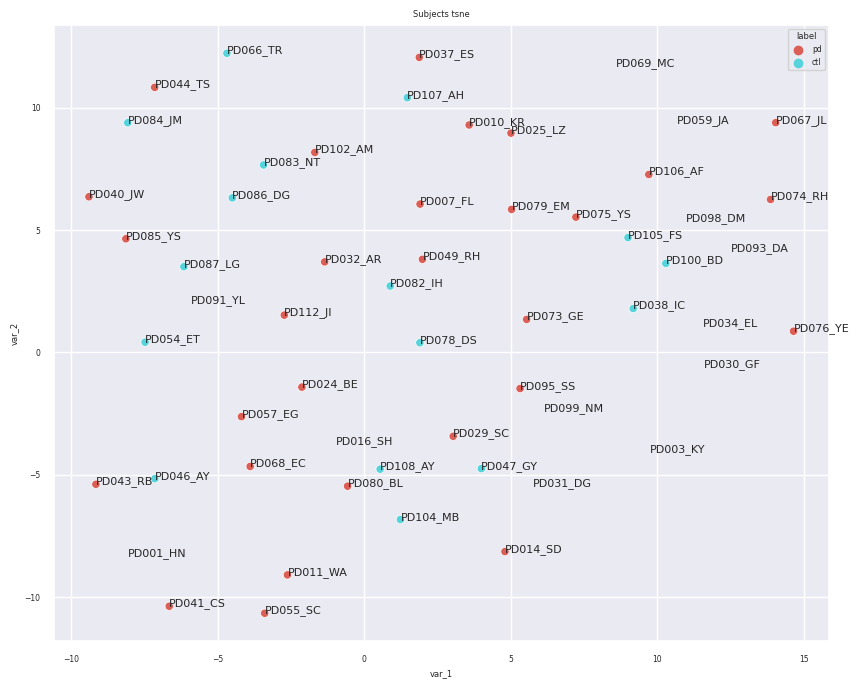

In [23]:
fig, ax = plt.subplots(figsize=(10,8))

sns.scatterplot(
    x="var_1", y="var_2",
    hue='label',
    palette=sns.color_palette("hls", 2),
    data=data_reduced_tsne,
    legend="full",
    ax=ax
    ).set_title('Subjects tsne')

for i, txt in enumerate(data_reduced_tsne.index):
    ax.annotate(txt, (data_reduced_tsne['var_1'][i], data_reduced_tsne['var_2'][i]), fontsize=8)


Rois clustering